In [1]:
#Installing Packages
%matplotlib inline
import numpy as np
import pandas as pd
import nltk


!pip install scikit-plot

import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import gensim
from gensim.models.doc2vec import Doc2Vec,TaggedDocument


#Nltk resource downloading
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
#Mounting Drive
!pip install kora -q
from kora import drive
drive.mount("/content/drive/")
drive.link_nbs()

     |████████████████████████████████| 57 kB 3.6 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
Mounted at /content/drive/


In [3]:
#Loading Pre-Processed File Exist
import os
file_path_x_train = "drive/MyDrive/Colab Notebooks/amazon_reviews_pre_processed_data/X_train.csv"
file_path_y_train = "drive/MyDrive/Colab Notebooks/amazon_reviews_pre_processed_data/Y_train.csv"
if os.path.isfile(file_path_x_train) and os.path.isfile(file_path_y_train) :
  X_train = pd.read_csv(file_path_x_train).fillna(' ')
  Y_train = pd.read_csv(file_path_y_train).fillna(' ')
  X_train = X_train.loc[:, ~X_train.columns.str.contains('^Unnamed')]
  Y_train = Y_train.loc[:, ~Y_train.columns.str.contains('^Unnamed')]
  print(X_train.shape)
  print('----------Training Data Loaded---------------------')


(3599999, 2)
----------Training Data Loaded---------------------


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.35, random_state=0, stratify=Y_train)

print(X_train.shape)
print(X_val.shape)

(2339999, 2)
(1260000, 2)


**Creating Word2Vec Vector**

In [ ]:
#Declaring Location to save Model
location = "drive/MyDrive/Colab Notebooks/amazon_reviews_models/Word2Vec/w2vmodel"
class Sentences(object):
    """Sentences is a generator to produce a list of tokenized sentences 
      Takes a list of numpy arrays containing documents.
    
    Args:
        object: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [ ]:
word2vec = get_word2vec(Sentences(X_train['title'].values + '' + X_train['text'].values))

Found drive/MyDrive/Colab Notebooks/amazon_reviews_models/Word2Vec/w2vmodel


In [ ]:
class Tokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = Tokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    def get_feature_len(self):
      words = self.word2vec.wv.vocab.keys()
      return len(words)

In [ ]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)
print(mean_embedding_vectorizer.get_feature_len())

343506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [ ]:
mean_embedded_train = mean_embedding_vectorizer.fit_transform(X_train['title'] + '' + X_train['text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [ ]:
print(len(X_train))

2339999


In [ ]:
#Creating Word2Vec Vectorizer For Validation Data
mean_embedded_val = mean_embedding_vectorizer.transform(X_val['title'] + '' + X_val['text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [ ]:
import joblib
#Saving Model
def save_model(model,filename):
  # save the model to disk
  joblib.dump(model, filename)
  print('Model Saved')

def get_model(filename):
  if os.path.isfile(filename):
    # load the model from disk
    print('Model Exist')
    loaded_model = joblib.load(filename)
    print('Model Loaded')
    return loaded_model
  print('Model does not exist')
  return None

In [ ]:
#GaussianNB
base_file_path = 'drive/MyDrive/Colab Notebooks/amazon_reviews_models/Word2Vec/'
# Checking If Model Exist then load it.
gaussian_nb_model_file_path = base_file_path + 'gausssian_nb_model.sav'
gaussian_nb_model =  get_model(gaussian_nb_model_file_path)
if gaussian_nb_model is None: 
  # Build the classifier
  gaussian_nb_model = GaussianNB()
  #  Train the classifier
  gaussian_nb_model.fit(mean_embedded_train, y_train)
  save_model(gaussian_nb_model,gaussian_nb_model_file_path)

Model does not exist


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Saved


In [ ]:
#BernoulliNB
base_file_path = 'drive/MyDrive/Colab Notebooks/amazon_reviews_models/Word2Vec/'
# Checking If Model Exist then load it.
bernoulli_nb_model_file_path = base_file_path + 'bernoulli_nb_model.sav'
bernoulli_nb_model =  get_model(bernoulli_nb_model_file_path)
if bernoulli_nb_model is None:
  # Build the classifier
  bernoulli_nb_model = BernoulliNB()
  #  Train the classifier
  bernoulli_nb_model.fit(mean_embedded_train, y_train)
  save_model(bernoulli_nb_model,bernoulli_nb_model_file_path)

Model Exist
Model Loaded


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator BernoulliNB from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


**Logistic Regression**

In [ ]:
#Logistic Regression
# Checking If Model Exist then load it.
log_reg_model_file_path = base_file_path + 'log_reg_model.sav'
log_reg_model =  get_model(log_reg_model_file_path)
if log_reg_model is None:
  log_reg_model = LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000)
  log_reg_model.fit(mean_embedded_train, y_train)
  save_model(log_reg_model,log_reg_model_file_path)

Model Exist
Model Loaded


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
#Hyperparameter Tuning [Updated]
params = {
              'logisticregression__C': [0.1, 1, 10, 100, 1000],
              }
log_reg_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('logisticregression', LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))])
log_reg_model_cv = GridSearchCV(log_reg_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
log_reg_model_cv.fit(bag_of_words_train[:10000], y_train[:10000])
bestParams = log_reg_model_cv.best_params_
print(f"Logistic Regression Model Best paramters: {bestParams})")

**Linear SVM**

In [ ]:
from sklearn.svm import LinearSVC
# Checking If Model Exist then load it.
linear_svc_model_file_path = base_file_path + 'linear_svc_model.sav'
linear_svc_model =  get_model(linear_svc_model_file_path)
if linear_svc_model is None:
  linear_svc_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('linearsvm', LinearSVC(tol=1e-5))])
  linear_svc_model.fit(mean_embedded_train, y_train)
  save_model(linear_svc_model,linear_svc_model_file_path)

Model Exist
Model Loaded


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator LinearSVC from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at yo

In [ ]:
#Hyperparameter Tuning [New Addition]
params = {
              'linearsvm__C': [0.1, 1, 10, 100, 1000],
              }
linear_svc_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('linearsvm', LinearSVC(tol=1e-5))])
linear_svc_model_cv = GridSearchCV(linear_svc_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
linear_svc_model_cv.fit(bag_of_words_train[:10000], y_train[:10000])
bestParams = linear_svc_model_cv.best_params_
print(f"Linear SVM Best paramters: {bestParams})")

**Decision Tree Classifier**

In [ ]:
#Finding Best Hyperparameter For Decision Tree
params = {
 'decisiontreeclassifier__max_depth': [10,15,20],
 'decisiontreeclassifier__min_samples_split': [2,4,6], 
 'decisiontreeclassifier__min_samples_leaf':[100,200,300]
}
# Checking If Model Exist then load it.
decision_tree_model_file_path = base_file_path + 'decision_tree_model.sav'
decision_tree_model =  get_model(decision_tree_model_file_path)
if decision_tree_model is None:
  decision_tree_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('decisiontreeclassifier', DecisionTreeClassifier(max_depth=10,min_samples_split=4,min_samples_leaf=300))])
  # decision_tree_model_cv = GridSearchCV(decision_tree_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
  decision_tree_model.fit(mean_embedded_train, y_train)
  save_model(decision_tree_model,decision_tree_model_file_path)
  # bestParams = modelCV.best_params_
  # print(f"Decision Tree Best paramters: {bestParams})")


Model Exist
Model Loaded


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid resul

**Random Forest Classifier**

In [ ]:
#Finding Best Hyperparameter For Random Forest
params = {
 'randomforestclassifier__max_depth': [10,15,20],
 'randomforestclassifier__min_samples_split': [2,4,6], 
 'randomforestclassifier__min_samples_leaf':[100,200,300]
}
# Checking If Model Exist then load it.
rf_model_file_path = base_file_path + 'rf_model.sav'
rf_model =  get_model(rf_model_file_path)
if rf_model is None:
  rf_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('randomforestclassifier', 
                  RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=4,min_samples_leaf=300))])
  # rf_model_cv = GridSearchCV(rf_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
  rf_model.fit(mean_embedded_train, y_train)
  save_model( rf_model, rf_model_file_path)
  # rf_best_params = rf_model_cv.best_params_
  # print(f"Random Forest Best paramters: {rf_best_params})")

Model Exist


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Model Loaded


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
def report(model,X,Y,modelName,report_type,accuracy_scores):
    YPred = model.predict(X)
    if report_type:
        print(f"{modelName} Training Data Result:\n================================================")
    else:
        print(f"{modelName} Test Data Result:\n================================================")
    model_accuracy_score = accuracy_score(Y, YPred) * 100
    print(f"Accuracy Score: {model_accuracy_score:.2f}%")
    print("_______________________________________________")
    clf_report = pd.DataFrame(classification_report(Y, YPred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    skplt.metrics.plot_confusion_matrix(Y, YPred)
    accuracy_scores.append(model_accuracy_score)


Gaussian NB Model Training Data Result:
Accuracy Score: 72.22%
_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  7.300542e-01  7.149001e-01  0.722219  7.224772e-01  7.224772e-01
recall     7.051906e-01  7.392476e-01  0.722219  7.222191e-01  7.222191e-01
f1-score   7.174071e-01  7.268700e-01  0.722219  7.221385e-01  7.221385e-01
support    1.170000e+06  1.169999e+06  0.722219  2.339999e+06  2.339999e+06


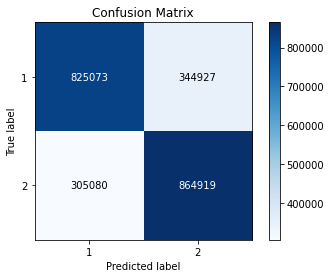

In [ ]:
training_accuracy_scores = []
report(gaussian_nb_model,mean_embedded_train,y_train,'Gaussian NB Model',True,training_accuracy_scores)

Bernoulli NB Model Training Data Result:
Accuracy Score: 69.13%
_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  6.907318e-01  6.918524e-01   0.69129  6.912921e-01  6.912921e-01
recall     6.927556e-01  6.898254e-01   0.69129  6.912905e-01  6.912905e-01
f1-score   6.917422e-01  6.908374e-01   0.69129  6.912898e-01  6.912898e-01
support    1.170000e+06  1.169999e+06   0.69129  2.339999e+06  2.339999e+06


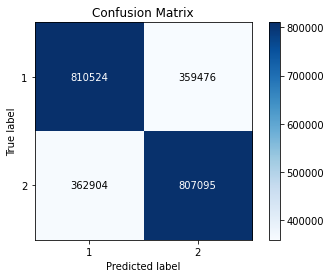

In [ ]:
report(bernoulli_nb_model,mean_embedded_train,y_train,'Bernoulli NB Model',True,training_accuracy_scores)

Logistic NB Model Training Data Result:
Accuracy Score: 85.70%
_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  8.570240e-01  8.569690e-01  0.856997  8.569965e-01  8.569965e-01
recall     8.569581e-01  8.570349e-01  0.856997  8.569965e-01  8.569965e-01
f1-score   8.569911e-01  8.570020e-01  0.856997  8.569965e-01  8.569965e-01
support    1.170000e+06  1.169999e+06  0.856997  2.339999e+06  2.339999e+06


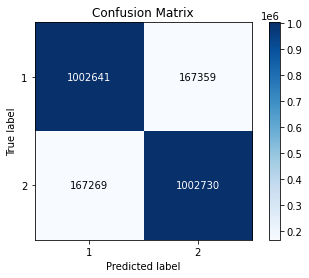

In [ ]:
report(log_reg_model,mean_embedded_train,y_train,'Logistic NB Model',True,training_accuracy_scores)

Linear SVC Model Training Data Result:
Accuracy Score: 85.60%
_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  8.481149e-01  8.641779e-01  0.855965  8.561464e-01  8.561464e-01
recall     8.672410e-01  8.446896e-01  0.855965  8.559653e-01  8.559653e-01
f1-score   8.575714e-01  8.543227e-01  0.855965  8.559470e-01  8.559470e-01
support    1.170000e+06  1.169999e+06  0.855965  2.339999e+06  2.339999e+06


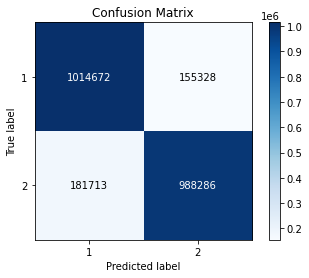

In [ ]:
report(linear_svc_model,mean_embedded_train,y_train,'Linear SVC Model',True,training_accuracy_scores)

Decision Tree Model Training Data Result:
Accuracy Score: 79.01%
_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  7.831277e-01  7.974682e-01  0.790121  7.902980e-01  7.902980e-01
recall     8.024709e-01  7.777708e-01  0.790121  7.901208e-01  7.901209e-01
f1-score   7.926813e-01  7.874963e-01  0.790121  7.900888e-01  7.900888e-01
support    1.170000e+06  1.169999e+06  0.790121  2.339999e+06  2.339999e+06


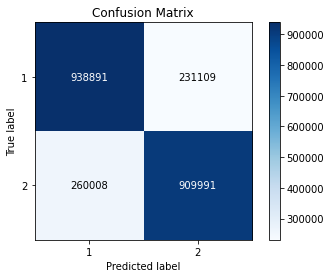

In [ ]:
report(decision_tree_model,mean_embedded_train,y_train,'Decision Tree Model',True,training_accuracy_scores)

Random Forest Model Training Data Result:
Accuracy Score: 81.90%
_______________________________________________
CLASSIFICATION REPORT:
                      1             2  accuracy     macro avg  weighted avg
precision  8.112021e-01  8.272265e-01  0.819013  8.192143e-01  8.192143e-01
recall     8.315632e-01  8.064631e-01  0.819013  8.190132e-01  8.190132e-01
f1-score   8.212565e-01  8.167128e-01  0.819013  8.189847e-01  8.189847e-01
support    1.170000e+06  1.169999e+06  0.819013  2.339999e+06  2.339999e+06


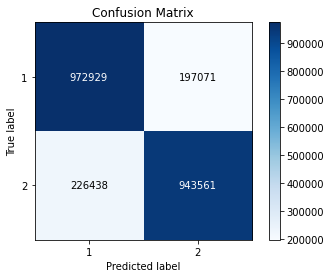

In [ ]:
report(rf_model,mean_embedded_train,y_train,'Random Forest Model',True,training_accuracy_scores)

**Validation Data Performance**

Gaussian NB Model Test Data Result:
Accuracy Score: 72.15%
_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy     macro avg  weighted avg
precision       0.729654       0.713861  0.721476  7.217574e-01  7.217574e-01
recall          0.703671       0.739281  0.721476  7.214762e-01  7.214762e-01
f1-score        0.716427       0.726348  0.721476  7.213879e-01  7.213879e-01
support    630000.000000  630000.000000  0.721476  1.260000e+06  1.260000e+06


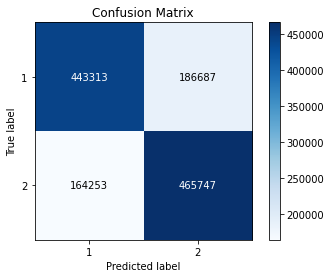

In [ ]:
validation_accuracy_scores = []
report(gaussian_nb_model,mean_embedded_val,y_val,'Gaussian NB Model',False,validation_accuracy_scores)

Bernoulli NB Model Test Data Result:
Accuracy Score: 69.08%
_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy     macro avg  weighted avg
precision       0.690602       0.691053  0.690827  6.908273e-01  6.908273e-01
recall          0.691417       0.690237  0.690827  6.908270e-01  6.908270e-01
f1-score        0.691009       0.690644  0.690827  6.908269e-01  6.908269e-01
support    630000.000000  630000.000000  0.690827  1.260000e+06  1.260000e+06


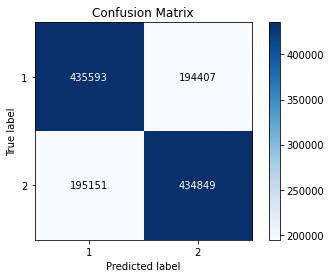

In [ ]:
report(bernoulli_nb_model,mean_embedded_val,y_val,'Bernoulli NB Model',False,validation_accuracy_scores)

Logistic Regression Model Test Data Result:
Accuracy Score: 85.66%
_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy     macro avg  weighted avg
precision       0.856719       0.856488  0.856603  8.566032e-01  8.566032e-01
recall          0.856441       0.856765  0.856603  8.566032e-01  8.566032e-01
f1-score        0.856580       0.856626  0.856603  8.566032e-01  8.566032e-01
support    630000.000000  630000.000000  0.856603  1.260000e+06  1.260000e+06


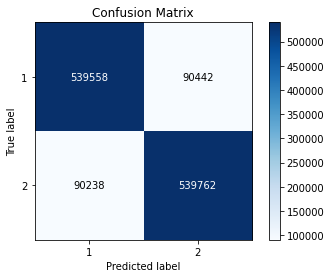

In [ ]:
report(log_reg_model,mean_embedded_val,y_val,'Logistic Regression Model',False,validation_accuracy_scores)

Linear SVC Model Test Data Result:
Accuracy Score: 85.58%
_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy     macro avg  weighted avg
precision       0.848032       0.863863  0.855771  8.559475e-01  8.559475e-01
recall          0.866890       0.844652  0.855771  8.557714e-01  8.557714e-01
f1-score        0.857357       0.854150  0.855771  8.557536e-01  8.557536e-01
support    630000.000000  630000.000000  0.855771  1.260000e+06  1.260000e+06


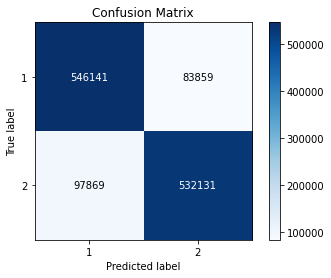

In [ ]:
report(linear_svc_model,mean_embedded_val,y_val,'Linear SVC Model',False,validation_accuracy_scores)

Decision Tree Model Training Data Result:
Accuracy Score: 78.39%
_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy     macro avg  weighted avg
precision       0.777192       0.790912  0.783887  7.840522e-01  7.840522e-01
recall          0.795962       0.771811  0.783887  7.838865e-01  7.838865e-01
f1-score        0.786465       0.781245  0.783887  7.838550e-01  7.838550e-01
support    630000.000000  630000.000000  0.783887  1.260000e+06  1.260000e+06


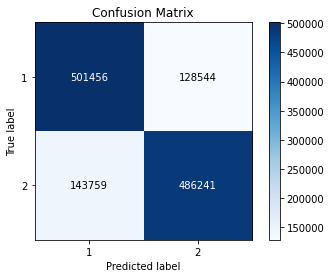

In [ ]:
report(decision_tree_model,mean_embedded_val,y_val,'Decision Tree Model',True,validation_accuracy_scores)

Random Forest Model Training Data Result:
Accuracy Score: 81.44%
_______________________________________________
CLASSIFICATION REPORT:
                       1              2  accuracy     macro avg  weighted avg
precision       0.806718       0.822410  0.814368  8.145640e-01  8.145640e-01
recall          0.826840       0.801897  0.814368  8.143683e-01  8.143683e-01
f1-score        0.816655       0.812024  0.814368  8.143394e-01  8.143394e-01
support    630000.000000  630000.000000  0.814368  1.260000e+06  1.260000e+06


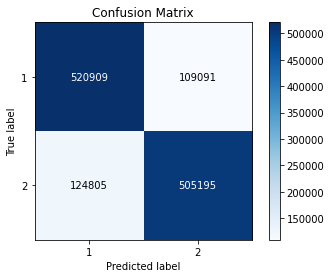

In [ ]:
report(rf_model,mean_embedded_val,y_val,'Random Forest Model',True,validation_accuracy_scores)

In [ ]:
def create_barplot(df,x_label,y_label,x_col,y_col,filename):
    plt.figure(figsize=(12,6),dpi=100)
    plt.style.use('ggplot')
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=x_col,y=y_col,data=df,palette="Set2")
    
    for bar in ax.patches:
      ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

    ax.set(xlabel=x_label, ylabel=y_label)
    ax.tick_params(axis='x', rotation=30)
    plt.setp(ax.patches, linewidth=0)
    # plt.legend(title = 'Team Name', bbox_to_anchor=(1, 1))
    file_path = f'drive/MyDrive/Colab Notebooks/amazon_reviews_model_results/{filename}.png'
    plt.savefig(file_path,bbox_inches = 'tight')
    plt.show()



In [ ]:
print(f'Training Accuracy Score -- {training_accuracy_scores}')
print(f'Validation Accuracy Score -- {validation_accuracy_scores}')

Training Accuracy Score -- [72.22191120594495, 69.12904663634471, 85.6996520083983, 85.59653230621038, 79.01208504789959, 81.90131705184488]
Validation Accuracy Score -- [72.14761904761905, 69.08269841269842, 85.66031746031746, 85.57714285714285, 78.3886507936508, 81.4368253968254]


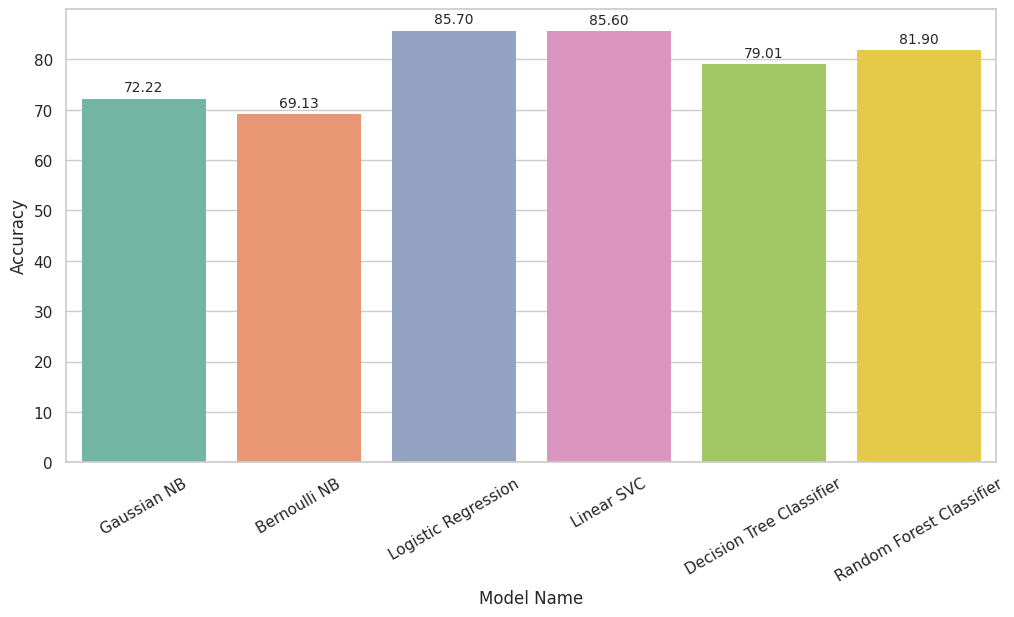

In [ ]:
model_name_list = ['Gaussian NB','Bernoulli NB','Logistic Regression','Linear SVC','Decision Tree Classifier','Random Forest Classifier']
df_train = pd.DataFrame(model_name_list,columns=['model_name'])
df_train['accuracy_score'] = training_accuracy_scores
df_val = pd.DataFrame(model_name_list,columns=['model_name'])
df_val['accuracy_score'] = validation_accuracy_scores
create_barplot(df_train,'Model Name','Accuracy','model_name','accuracy_score','word2vec_train_accuracy')

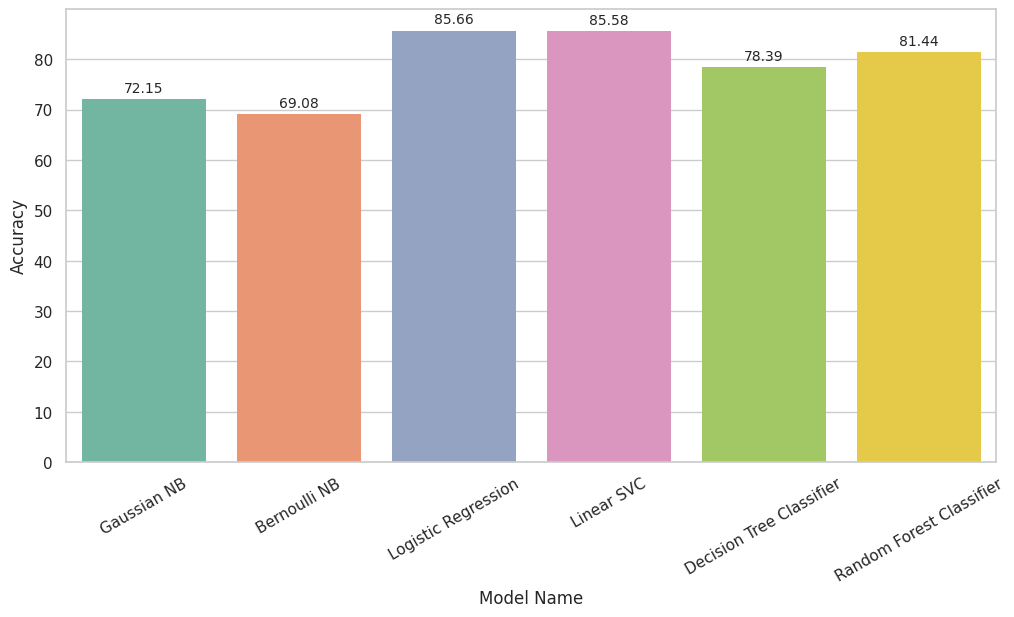

In [ ]:
create_barplot(df_val,'Model Name','Accuracy','model_name','accuracy_score','word2vec_val_accuracy')

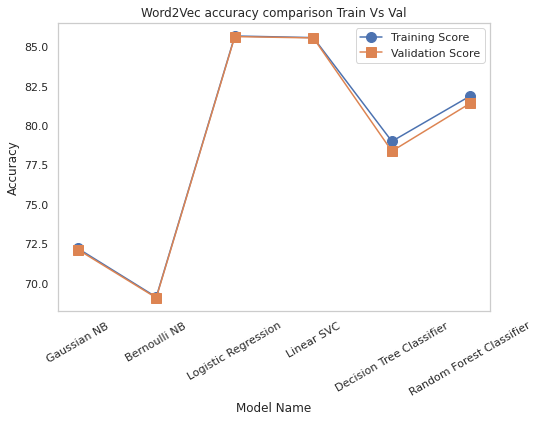

In [ ]:
#Creating Canvas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_ylabel('Accuracy')
ax.set_xlabel('Model Name')
ax.set_title('Word2Vec accuracy comparison Train Vs Val')

#Creating Multiline Plot
ax.plot(model_name_list,training_accuracy_scores, label="Training Score",marker='o',ms=10)
ax.plot(model_name_list,validation_accuracy_scores, label="Validation Score",marker='s',ms=10)

ax.grid(False)
ax.set_facecolor('white')
ax.legend()
ax.tick_params(axis='x', rotation=30)
file_path = f'drive/MyDrive/Colab Notebooks/amazon_reviews_model_results/word2vec_accuracy_comp.png'
plt.savefig(file_path,bbox_inches = 'tight')
plt.show()
plt.close()

**Best Model is Logistic Regression Model based on Validation Accuracy**